# A short introduction to `numpy`, `scipy` and `matplotlib`

## TOC
* [python arrays (`numpy`)](#numpy)
* [visualizing data and models (`matplotlib`)](#matplotlib)
* [fitting a simple (linear) model on data](#fit)
* [computing integrals](#integrals)
* [integrating ordinary differential equations](#ode)

*** 

<a id="ode"></a>
## Integrating ordinary differential equations

Differential equation:

$$
y'+ y = x, \ \ \mathrm{with}\ \ y(0) = 1
$$

In [8]:
import pylab as pl 
pl.rcParams.update({'font.size': 16})

import scipy.integrate as integrate

def dy_dx(y, x):
    return x - y

xx = np.linspace(0., 5., 100)
y0 = 1.
yy = integrate.odeint(dy_dx, y0, xx)

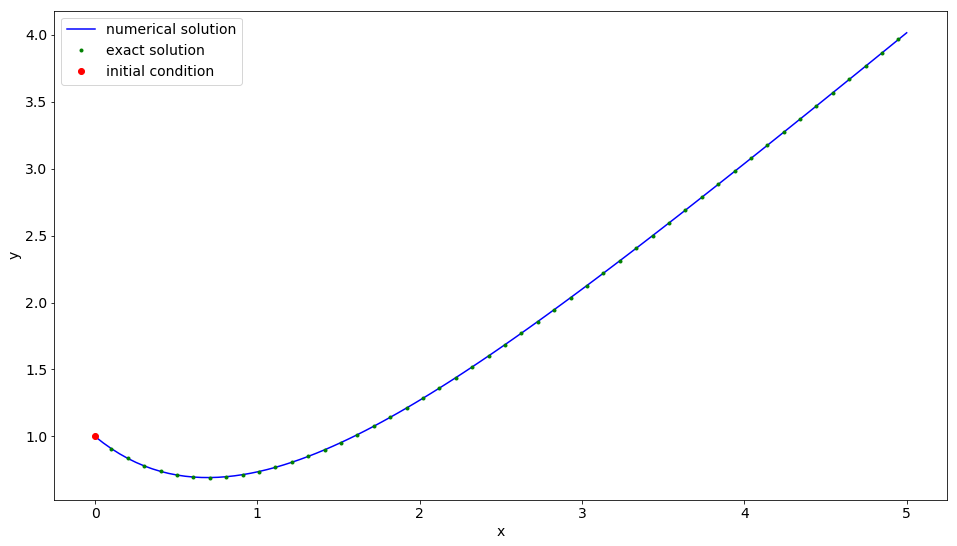

In [9]:
# now, we plot the result of our numerical integration
# and compare it with the exact solution (by chance, has one)

def exact_solution(x):
    return x - 1. + 2. * np.exp(-x)

pl.rcParams.update({'font.size': 14})
pl.figure(figsize=(16,9))
pl.plot(xx, yy, 'b-', label='numerical solution')
pl.plot(xx[::2], exact_solution(xx[::2]), 'g.', label='exact solution')
pl.plot(0., y0, 'ro', label='initial condition')
pl.xlabel('x')
pl.ylabel('y')
pl.legend(loc='upper left')

Text(0,0.5,'exact-numerical')

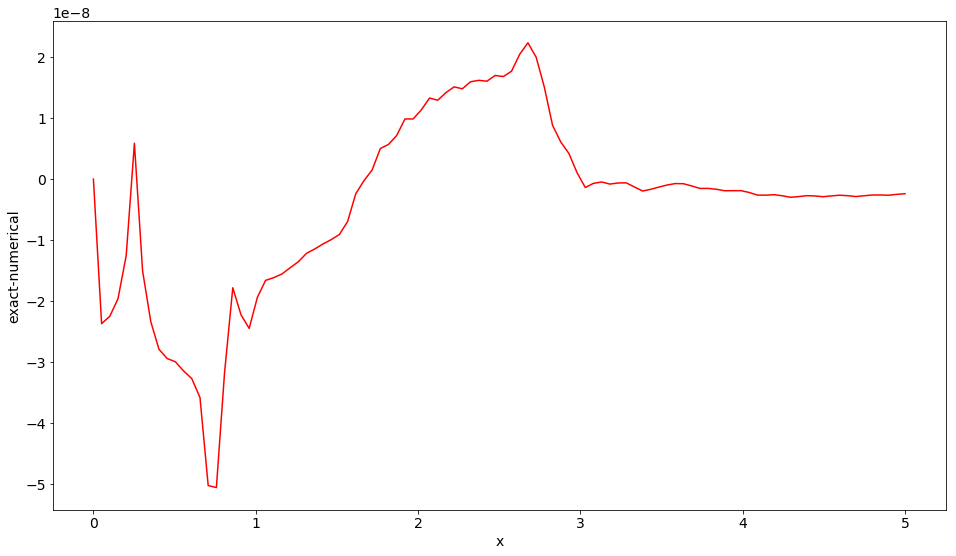

In [10]:
# pretty close ! 
# let's compare the exact and numerical solutions more closely
pl.figure(figsize=(16,9))
pl.plot(xx, exact_solution(xx)-yy.flatten(), 'r-')
pl.xlabel('x')
pl.ylabel('exact-numerical')

In [11]:
# what if the boundary condition is not at zero ? 
# for example: $y(2) == 2$
# the solution I know, is to solve backwards and forwards

xx_forwards  = np.linspace(2, 10, 100)
yy_forwards = integrate.odeint(dy_dx, 2., xx_forwards)
xx_backwards = np.linspace(2,  0., 50)
yy_backwards = integrate.odeint(dy_dx, 2., xx_backwards)

(0, 10.0)

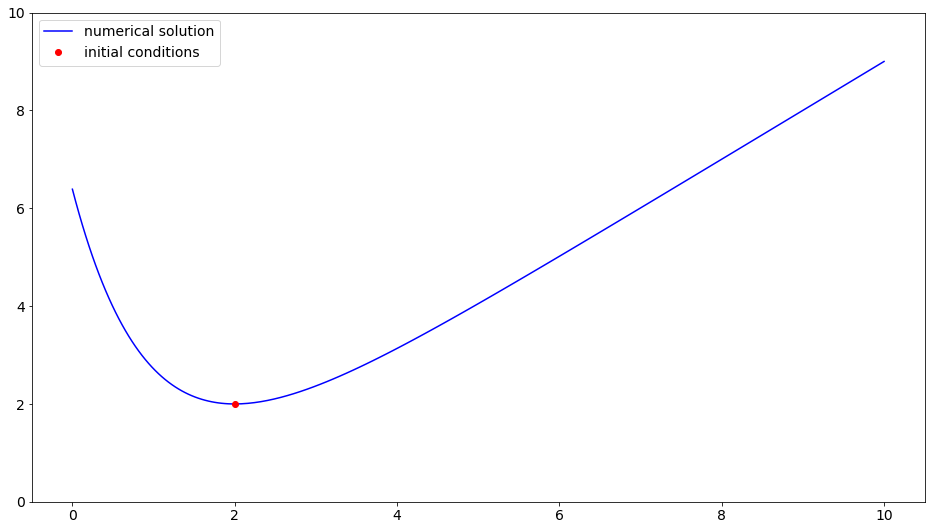

In [12]:
pl.figure(figsize=(16,9))
pl.plot(xx_forwards, yy_forwards, 'b-', label='numerical solution')
pl.plot(xx_backwards, yy_backwards, 'b-')
pl.plot(2., 2., 'ro', label='initial conditions')
pl.legend(loc='upper left')
pl.ylim((0, 10.))

### Second order ordinary differential equations

Finally, let's consider a second order differential equation, such as, for example, the pendulum equation:

$$
\theta''(t) + b \theta'(t) + c \sin\theta(t) = 0
$$

it may be solved with `odeint` provided that we express it as a first order ordinary differential equation. Classically, this is done as follows:

$$
\begin{bmatrix} \theta \\ \theta' \end{bmatrix}' = \begin{bmatrix} \theta' \\ -b \theta' -c \sin\theta\end{bmatrix} = \mathbf{F}\left(\begin{bmatrix} \theta \\  \theta' \end{bmatrix}\right)
$$

In [13]:
def dy_dx(y, t, b, c):
    theta, d_theta_dt = y
    return [d_theta_dt, -b * d_theta_dt -c * np.sin(theta)]

b, c = 0.25, 5.
y0 = [np.pi-0.1, 0.]
t = np.linspace(0., 10, 100)
y = integrate.odeint(dy_dx, y0, t, args=(b, c,))

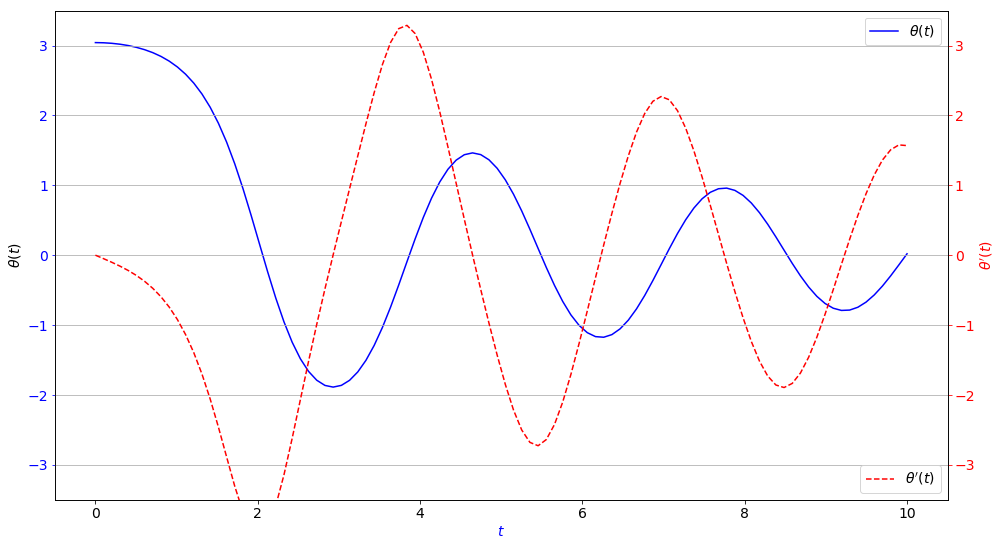

In [14]:
pl.figure(figsize=(16,9))
ax = pl.subplot(111)
pl.plot(t, y.T[0], 'b-', label='$\\theta(t)$')
pl.xlabel('$t$', color='b')
pl.ylabel('$\\theta(t)$')
pl.legend(loc='upper right')
pl.ylim((-3.5,3.5))
ax.tick_params('y', colors='b')

ax2 = pl.twinx()
ax2.plot(t, y.T[1], 'r--', label="$\\theta'(t)$")
pl.ylabel("$\\theta'(t)$", color='r')
pl.legend(loc='lower right')
pl.ylim((-3.5,3.5))
ax2.tick_params('y', colors='r')
pl.grid(1)

## Equations de Friedmann

In [15]:
from scipy import integrate

H0=71000/(3.E22)*(3600*24*365.E9)
omega_m = 0.3
omega_l = 0.0
omega_r = 5.E-4

def dy_dt(y,x, H0, omega_m, omega_r, omega_l):
    omega_k = 1. - omega_m - omega_r - omega_l
    a, adot = y[0], y[1]
    adotdot = -0.5 * H0**2 * omega_m * (omega_m / a**3 + omega_r / a**4 - 2 * omega_l) / (adot**2 / H0**2 - omega_r / a**2 - a**2 * omega_l - omega_k)
    return [adot, adotdot]

def adot(a, H0, omega_m, omega_r, omega_l):
    omega_k = 1 - omega_m - omega_r - omega_l
    return H0 * np.sqrt(omega_m / a + omega_r / a**2 + omega_k + omega_l * a**3)

def compute(H0, omega_m, omega_r, omega_l):
    a0 = (1., adot(1., H0, omega_m, omega_r, omega_l))
    t_forwards = np.linspace(0., 50, 100)
    a_forwards = integrate.odeint(dy_dt, a0, t_forwards, args=(H0, omega_m, omega_r, omega_l))
    t_backwards = np.linspace(0., -14, 100)
    a_backwards = integrate.odeint(dy_dt, a0, t_backwards, args=(H0, omega_m, omega_r, omega_l))
    return t_forwards, a_forwards, t_backwards, a_backwards


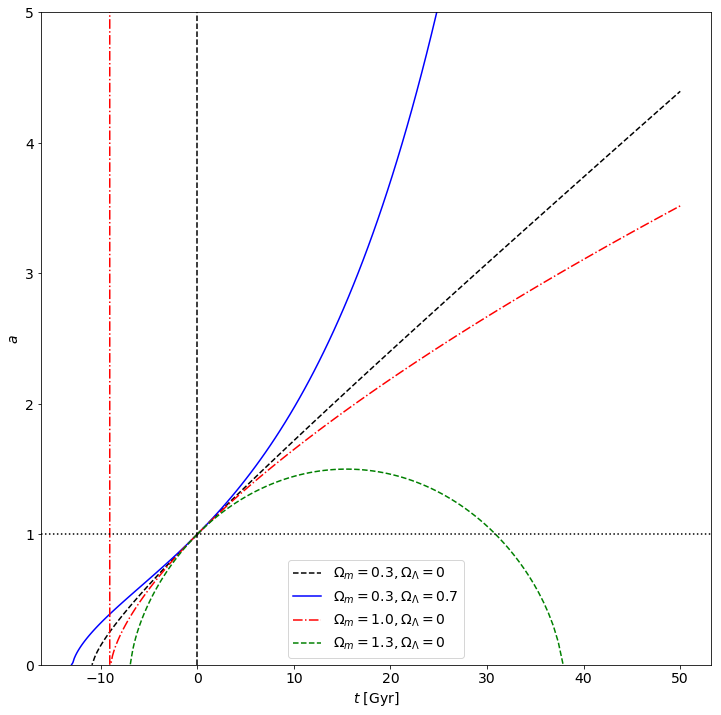

In [16]:
def plot(t_f, a_f, t_b, a_b, color='r', ls='-', label=''):
    idx = a_f.T[0] > 1.E-6
    pl.plot(t_f[idx], a_f.T[0][idx], color=color, ls=ls, label=label)
    idx = a_b.T[0] > 1.E-6
    pl.plot(t_b[idx], a_b.T[0][idx], color=color, ls=ls)
    t_f[:] = 0.
    a_f[:] = 0.
    t_b[:] = 0.
    a_b[:] = 0.


pl.figure(figsize=(12,12))
plot(*compute(H0, 0.3, 5.E-4, 0.0), ls='--', color='k', label='$\Omega_m=0.3, \Omega_\Lambda=0$')
plot(*compute(H0, 0.3, 5.E-4, 0.7), ls='-', color='b', label='$\Omega_m=0.3, \Omega_\Lambda=0.7$')
plot(*compute(H0, 1.0, 5.E-4, 0.0), ls='-.', color='r', label='$\Omega_m=1.0, \Omega_\Lambda=0$')
plot(*compute(H0, 3, 5.E-4, 0.0), ls='--', color='g', label='$\Omega_m=1.3, \Omega_\Lambda=0$')
pl.legend(loc='best')
pl.ylim((0., 5.))
pl.xlabel('$t$ [Gyr]')
pl.ylabel('$a$')
pl.axvline(0., color='k', ls='--')
pl.axhline(1., color='k', ls=':')